# Store kitti sequence

Create a sequence

In [1]:
# when you change a setting you have to restart the kernel (settings are only loaded once)
import os
#os.environ['STEREO_CONFIDENCE'] = '1.6'
#os.environ['SEQUENCE_CONFIDENCE'] = '1.6'
#os.environ['PATCH_SIZE'] = '17'
FRAMECOUNT = 1101

import sys
sys.path.append('..')
from src.kitti import *
%matplotlib inline
import numpy as np
import glob
import urbg2o
import cv2


IMAGE_SIZE = 400

def load(file):
    keyframeids, frameids, poses = load_keyframes(file)
    return keyframeids, frameids, poses.reshape(poses.shape[0], 4, 4)

def load_csv(file):
    poses = np.genfromtxt(file, delimiter= " ")
    poses = np.hstack([poses, np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) ])
    return poses.reshape(poses.shape[0], 4, 4)

def transform(poses):
    points = np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) 
    for i in range(1, len(poses)):
        points[:i] = np.dot(points[:i], poses[i].T)
    return points
        
def transform2(poses):
    points = poses[:,:,3]
    return points
    
def plot_trajectory(points):
    # remove y coordinate (we only use x and z to plot a view from above)
    points = points[:, [0,2,3]]
    # compute min and max
    pmin = points.min(axis=0)
    pmax = points.max(axis=0)
    maxxy = max(pmax[0] - pmin[0], pmax[1] - pmin[1])

    t = np.eye(3, dtype=np.float64)
    t[0,0] = IMAGE_SIZE / maxxy
    t[1,1] = -IMAGE_SIZE / maxxy
    t[0,2] = -pmin[0] * IMAGE_SIZE / maxxy
    t[1,2] = IMAGE_SIZE / maxxy + pmin[1] / maxxy + 100

    return np.dot(points, t.T)
    

def plot_trajectory2(points):
    # remove y coordinate (we only use x and z to plot a view from above)
    points = points[:, [0,2,3]]
    # compute min and max
    pmin = points.min(axis=0)
    pmax = points.max(axis=0)
    maxxy = max(pmax[0] - pmin[0], pmax[1] - pmin[1]) * 1.01

    t = np.eye(3, dtype=np.float64)
    t[0,0] = IMAGE_SIZE / maxxy
    t[1,1] = -IMAGE_SIZE / maxxy
    t[0,2] = -pmin[0] * IMAGE_SIZE / maxxy
    t[1,2] = IMAGE_SIZE / maxxy + pmin[1] / maxxy + 100
    return np.dot(points, t.T)
    
def plot_trajectory3(points):
    coords = []
    minx = min([p[0] for p in points])
    maxx = max([p[0] for p in points])
    miny = min([p[2] for p in points])
    maxy = max([p[2] for p in points])
    maxxy = max(maxx - minx, maxy - miny)* 1.01

    for p in points:
        #print(p)
        x = IMAGE_SIZE * (p[0] - minx) / (maxxy)
        z = IMAGE_SIZE - IMAGE_SIZE * (p[2] - miny) / (maxxy)
        coords.append([x, z])
    return coords

def new_image():
    img = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), np.uint8)
    img[:] = 255 #or img.fill(255)
    return img

def draw(coords, img, color = (0,0,0)):
    # Draw a black line with thickness of 2 px
    for i in range(1,len(coords)):
        cv2.line(img, (int(coords[i - 1][0]), int(coords[i - 1][1])), (int(coords[i][0]), int(coords[i][1])), color, 2)
    return img

Read the first 10 frames from KITTI sequence 00.

In [2]:
%%time
LEFTDIR = '/data/urbinn/datasets/kitti/sequences/00/image_2'
RIGHTDIR = '/data/urbinn/datasets/kitti/sequences/00/image_3'

frame = []
for filename in sorted(glob.glob(LEFTDIR + '/*')):
    left_frame = Frame(filename, RIGHTDIR)
    frame.append(left_frame)

CPU times: user 15.9 ms, sys: 3.66 ms, total: 19.5 ms
Wall time: 100 ms


Add the frames to a sequence. By adjusting the [:] you can use only a slice of the list of frames.

In [5]:
seq = Sequence()
for f in ProgressBar()(frame[:20]):
    seq.add_frame(f)

 35% (7 of 20) |#########                 | Elapsed Time: 0:00:08 ETA:  0:00:16

invalid speed keyframe 0 frame 7 speed 4.552316993127173
 [[  9.99999646e-01   3.81799580e-04  -7.50215002e-04   3.59772007e-02]
 [ -3.81800734e-04   9.99999927e-01  -1.39487441e-06  -1.19480971e-03]
 [  7.50214415e-04   1.68130655e-06   9.99999719e-01  -7.87199107e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


 80% (16 of 20) |####################     | Elapsed Time: 0:00:26 ETA:  0:00:07

invalid speed keyframe 11 frame 16 speed 7.350968992017931
 [[  9.98789798e-01  -4.71527742e-02   1.39841142e-02  -2.01725204e+00]
 [  4.71603873e-02   9.98887307e-01  -2.14966617e-04   8.12109396e-01]
 [ -1.39584179e-02   8.74202704e-04   9.99902194e-01   3.79091360e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


100% (20 of 20) |#########################| Elapsed Time: 0:00:33 Time: 0:00:33


Example of how to save a set of covisible keyframes, fixed keyframes, mappoints and edges to use for local bundle adjustment

Keyframes count
 4 

Keyframes before BA 
 [[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]
 [  9.99834865e-01  -8.99392248e-04   1.81503065e-02   4.71273840e-02
    1.00338211e-03   9.99983131e-01  -5.72107928e-03   4.24170229e-02
   -1.81448549e-02   5.73834623e-03   9.99818901e-01  -4.07096603e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]
 [  9.99967938e-01   4.49286541e-03   6.62855931e-03   6.80430993e-02
   -4.49012426e-03   9.99989828e-01  -4.28359501e-04   3.92038136e-02
   -6.63041644e-03   3.98582711e-04   9.99977939e-01  -3.56005539e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]
 [  9.99670260e-01   2.30058644e-04   2.56771784e-02  -5.26396407e-02
   -4.15246694e-04   9.99973943e-01   7.2070

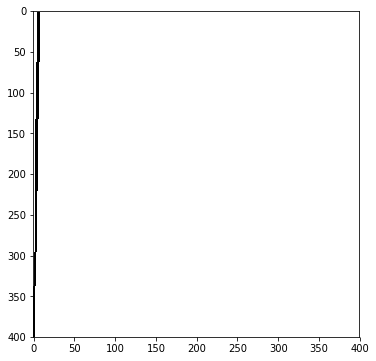

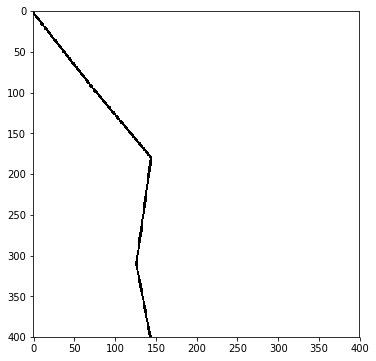

In [6]:

print('Keyframes count\n', (len(seq.keyframes)), '\n')

cv_keyframes = get_covisible_keyframes(seq.keyframes[1])
mappoints = get_mappoints(cv_keyframes)
f_keyframes = get_fixed_keyframes(mappoints, cv_keyframes)

cv_keyframes_np = keyframes_to_np(cv_keyframes)
f_keyframes_np = keyframes_to_np(f_keyframes)
mappoints_np = mappoints_to_np(mappoints)
links_np = links_to_np(mappoints)


f_keyframes = np.asfortranarray(f_keyframes_np)
cv_keyframes_BA = np.asfortranarray(cv_keyframes_np)
mappoints = np.asfortranarray(mappoints_np)
links = np.array(links_np, order='f')


print('Keyframes before BA \n', (cv_keyframes_BA[:, 2 :]), '\n')
print(len(mappoints_np), '\n')

result =  urbg2o.localBundleAdjustment(cv_keyframes_BA, f_keyframes, mappoints, links)

print('Keyframes after BA \n', (cv_keyframes_BA[:, 2 :]), '\n')


print('Keyframes \n', (cv_keyframes), '\n')
print('Keyframes numpy \n', (cv_keyframes_np[:, 2 :]), '\n')
print(len(mappoints_np), '\n')
print('Fixed Keyframes \n',f_keyframes[:], '\n')
# print( keyframes_to_np( [seq.keyframes[1]]  )[:, 2 :] , '\n')


# print(cv_keyframes[:, 0 :], '\n')

np_matrix_values =  cv_keyframes_np[:,2 :]


# draw seq.keyframes

# array_value = []
# for i in range(0, len(keyframes_to_np(seq.keyframes)[:,2 :]) ):
#     array_value.append(  np.split(keyframes_to_np(seq.keyframes)[:,2 :][i], 4 )  )
# np_array_value = np.array(array_value)

# points = transform( np_array_value )
# coords = plot_trajectory3(points)
# p = draw(coords, new_image())
# show(p)



#old points 
array_value = []
for i in range(0, len(np_matrix_values) ):
    array_value.append(  np.split(np_matrix_values[i], 4 )  )
np_array_value = np.array(array_value)

points = transform( np_array_value )
coords = plot_trajectory3(points)
p = draw(coords, new_image())
show(p)

#new points

start_array_value = []
for i in range(0, len(cv_keyframes_BA[:,2 :] ) ):
    start_array_value.append(  np.split(cv_keyframes_BA[:,2 :][i], 4 )  )
start_array_value = np.array(start_array_value)

points_start = transform( start_array_value )
coords_start = plot_trajectory3(points_start)
p_start = draw(coords_start, new_image())
show(p_start)


keyframes_np_MO = keyframes_to_np(seq.keyframes)

# np.save('cv_keyframes', cv_keyframes_np)
# np.save('f_keyframes', f_keyframes_np)
# np.save('mappoints', mappoints_np)
# np.save('links', links_np)
